# Problem Statement

The Indian Premier League (IPL) is a professional league for Twenty20 cricket championship in India. It started in the year 2007-2008 and is running in its ninth year of existence. The pattern of the league is such that each team plays all other teams twice in the league stage, one in the HOME venue and other in the AWAY venue. After the league stage top four teams enter the semi-final stage and the top two teams enter the final contest.

## Objective

The goal of the contest is to develop a model to predict likelihood of a team winning the match. The true label of which team (team batting first or second) won the match is provided as “Team Won”. See data dictionary for more explanation. 

## Dataset

Dataset on all match statistics plus some derived features from season 2008 to 2012 is provided as an attachment supported by a data dictionary for the same.
The training dataset contains match statistics from 2008 to 2011 season. And the test dataset contains match statistics from 2012 season. 
-- train data : train.csv
-- test data  : test.csv
-- data dictionary : data_dictionary.xlsx

## Expectations

We are looking for prediction of a team (either Team 1 or Team 2) winning the match & probability score for the team winning the game.


 We will first **import the libraries** which we will use.

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from scipy.stats import poisson,skellam

***Importing the Training and Test Dataset***

In [155]:
train = pd.read_csv("sigtuple_train.csv")
test = pd.read_csv("sigtuple_test.csv")

***Data Exploration to find the DataTypes of the attributes***

In [156]:
train.dtypes

Game ID                                                               int64
Team 1                                                               object
Team 2                                                               object
City                                                                 object
DayOfWeek                                                             int64
DateOfGame                                                           object
TimeOfGame                                                           object
AvgWindSpeed                                                          int64
AvgHumidity                                                         float64
Inn 1 Team 1 NOP R>25,SR>125                                          int64
Inn 1 Team 1 NOP R<25, SR>125                                         int64
Inn 1 Team 1 Total 4s                                                 int64
Inn 1 Team 1 Total 6s                                                 int64
Inn 1 Team 1

***To find if there are any missing values in the data.***<br>
***We found out that No value was missing from the data.***

In [157]:
train.isnull().sum()

Game ID                                                             0
Team 1                                                              0
Team 2                                                              0
City                                                                0
DayOfWeek                                                           0
DateOfGame                                                          0
TimeOfGame                                                          0
AvgWindSpeed                                                        0
AvgHumidity                                                         0
Inn 1 Team 1 NOP R>25,SR>125                                        0
Inn 1 Team 1 NOP R<25, SR>125                                       0
Inn 1 Team 1 Total 4s                                               0
Inn 1 Team 1 Total 6s                                               0
Inn 1 Team 1 Max Strike Rate_ALLBatsmen                             0
Inn 1 Team 2 NoP fas

***Initial Rows of the Data to get the look of how the dataset actually looks like.***

In [158]:
train.head()

,Game ID,Team 1,Team 2,City,DayOfWeek,DateOfGame,TimeOfGame,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125",...,"Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 2 Total 4s,Inn 2 Team 2 Total 6s,Inn 2 Team 2 Max Strike Rate_ALLBatsmen,Inn 2 Team 1 NoP fast bowlers,Inn 2 Team 1 NoP Spinners,Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,"Winner (team 1=1, team 2=0)"
0,1,Koramangala Traffic Jammers,Whitefield Water Loggers,Whitefield,1,01-01-2012,20:00:00,6,0.49,1,...,0,3,3,120.00,5,0,6,4,11,1
1,2,Electronic City Power Savers,Silkboard Slow Movers,Silkboard,2,01-02-2012,17:00:00,7,0.44,3,...,2,18,9,215.15,4,1,4,0,5,1
2,3,Indranagar Pub Watchers,Sarjapur Water Tankers,Sarjapur,3,01-03-2012,20:30:00,11,0.23,2,...,1,18,1,300.00,3,3,0,1,10,0
3,4,Bellandur Froth Fighters,Koramangala Traffic Jammers,Koramangala,4,01-04-2012,16:00:00,6,0.61,0,...,0,5,4,100.00,4,2,3,2,16,0
4,5,Marathalli Chokers,Whitefield Water Loggers,Marathalli,5,01-05-2012,20:00:00,6,0.56,3,...,3,15,6,205.26,4,2,4,1,5,0


In [159]:
train.columns

Index(['Game ID', 'Team 1', 'Team 2', 'City', 'DayOfWeek', 'DateOfGame',
       'TimeOfGame', 'AvgWindSpeed', 'AvgHumidity',
       'Inn 1 Team 1 NOP R>25,SR>125', 'Inn 1 Team 1 NOP R<25, SR>125',
       'Inn 1 Team 1 Total 4s', 'Inn 1 Team 1 Total 6s',
       'Inn 1 Team 1 Max Strike Rate_ALLBatsmen',
       'Inn 1 Team 2 NoP fast bowlers', 'Inn 1 Team 2 NoP Spinners',
       'Inn 1 Team 2 wickets taken_catches_runout',
       'Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 1 Team 2 Extras conceded in_wides_No Balls',
       'Inn 2 Team 2 NOP R>25,SR>125', 'Inn 2 Team 2 NOP R<25, SR>125',
       'Inn 2 Team 2 Total 4s', 'Inn 2 Team 2 Total 6s',
       'Inn 2 Team 2 Max Strike Rate_ALLBatsmen',
       'Inn 2 Team 1 NoP fast bowlers', 'Inn 2 Team 1 NoP Spinners',
       'Inn 2 Team 1 wickets taken_catches_runout',
       'Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 2 Team 1 Extras conceded in_wides_No Balls',
       'Win

***Define X as features and y as lablels(category)***

In [160]:
y = train['Winner (team 1=1, team 2=0)']
X = train.drop(['Winner (team 1=1, team 2=0)'], axis=1)

***Creating a training set for modeling and validation set to check model performance. Split the training data into Validation set with size of 10% of the training data***

In [161]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.9, random_state=1234)

D:\Softwares\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


***We will only identify categorical variables. We will not perform any preprocessing steps for categorical variables and we perform this as follows***

In [162]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 24, 25, 26, 27, 28], dtype=int64)

***We will first use CatBoost, a recently opened Machine Learing Algorithm mainly used for Categorical Data.
It is especially powerful in two ways:***
1. It yields state-of-the-art results without extensive data training typically required by other machine learning methods, and
2. Provides powerful out-of-the-box support for the more descriptive data formats that accompany many business problems.<br>
It is a very easy implementation 

Now we will build the model

In [163]:
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X, y,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4771034	test: 0.4818409	best: 0.4818409 (0)	total: 51.9ms	remaining: 2.54s
1:	learn: 0.4549798	test: 0.4571380	best: 0.4571380 (1)	total: 66.2ms	remaining: 1.59s
2:	learn: 0.4413466	test: 0.4426140	best: 0.4426140 (2)	total: 70.2ms	remaining: 1.1s
3:	learn: 0.4263668	test: 0.4259326	best: 0.4259326 (3)	total: 75.4ms	remaining: 867ms
4:	learn: 0.4157645	test: 0.4125922	best: 0.4125922 (4)	total: 80.9ms	remaining: 728ms
5:	learn: 0.4029331	test: 0.3980920	best: 0.3980920 (5)	total: 85.3ms	remaining: 626ms
6:	learn: 0.3936377	test: 0.3892137	best: 0.3892137 (6)	total: 89.6ms	remaining: 551ms
7:	learn: 0.3852807	test: 0.3847524	best: 0.3847524 (7)	total: 99ms	remaining: 520ms
8:	learn: 0.3756037	test: 0.3746629	best: 0.3746629 (8)	total: 104ms	remaining: 473ms
9:	learn: 0.3677548	test: 0.3668918	best: 0.3668918 (9)	total: 109ms	remaining: 435ms
10:	learn: 0.3624680	test: 0.3609491	best: 0.3609491 (10)	total: 112ms	remaining: 398ms
11:	learn: 0.3549095	test: 0.3546590	best: 0.35

***As you can see that a basic model is giving a fair solution and training & testing error are in sync. You can tune model parameters, features to improve the solution.***

***Now we will apply this to the test set and calculate the accuracy.***

***First we will Rename two columns in test data as there is mismatch in the name of these column in training and test set.***

In [164]:
test = test.rename(columns = {"CityOfGame": "City", "Day":"DayOfWeek"})
test.columns

Index(['Game ID', 'Team 1', 'Team 2', 'City', 'DayOfWeek', 'DateOfGame',
       'TimeOfGame', 'AvgWindSpeed', 'AvgHumidity',
       'Inn 1 Team 1 NOP R>25,SR>125', 'Inn 1 Team 1 NOP R<25, SR>125',
       'Inn 1 Team 1 Total 4s', 'Inn 1 Team 1 Total 6s',
       'Inn 1 Team 1 Max Strike Rate_ALLBatsmen',
       'Inn 1 Team 2 NoP fast bowlers', 'Inn 1 Team 2 NoP Spinners',
       'Inn 1 Team 2 wickets taken_catches_runout',
       'Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 1 Team 2 Extras conceded in_wides_No Balls',
       'Inn 2 Team 2 NOP R>25,SR>125', 'Inn 2 Team 2 NOP R<25, SR>125',
       'Inn 2 Team 2 Total 4s', 'Inn 2 Team 2 Total 6s',
       'Inn 2 Team 2 Max Strike Rate_ALLBatsmen',
       'Inn 2 Team 1 NoP fast bowlers', 'Inn 2 Team 1 NoP Spinners',
       'Inn 2 Team 1 wickets taken_catches_runout',
       'Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 2 Team 1 Extras conceded in_wides_No Balls',
       'Win

***Define X as features and y as lablels(category) like we did in training data***

In [165]:
y_test = test['Winner (team 1=1, team 2=0)']
X_test = test.drop(['Winner (team 1=1, team 2=0)'], axis=1)

***Now we will run the CatBoost model trained on training data on test data and see how it works***

In [166]:
y_pred = model.predict(X_test)
print(y_pred)
y_pred = pd.DataFrame(y_pred.round()) 

[0.01980277 0.07337632 0.46677729 0.8678138  0.63512048 1.0092472
 0.95111725 0.55884229 0.17547298 0.85436814 0.02962251 0.99637378
 0.58859864 0.06680319 0.1136427  0.0743092  0.48890414 0.98297974
 0.11616953 0.53965595 0.20284972 0.03075829 0.55456334 0.61685231
 0.3205499  0.05033078 0.63323759 0.17518889 0.37963015 0.64242207
 0.03809004 0.02148839 0.56459216 0.02148839 0.61526992 0.77545205
 0.67534739 0.43596355 0.05888167 0.2390765  0.16583074 0.54415384
 0.05403058 0.52822114 0.43826866 0.59694082 0.68490566 0.86535146
 0.85495414 0.20817006 0.13550446 0.04248443 0.85220623 0.08453686
 0.06128954 0.52953171 0.54531264 0.09004741 0.03862652 0.96376409
 0.51304126 0.60366489 0.24099482 0.29627322 0.90300034 0.33872165
 0.86402783 0.50935637 0.1835261  0.85728612 0.85071897 0.02450154
 0.84213188 0.96137001 0.97064872 0.5968183 ]


***Calculate the accuracy score of the CataBoost Model***

In [167]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7763157894736842

## Now we will try to increase the accuracy using other Machine Learning Algorithms

***Import the data again and prepare it for the models (Data Preparation task is very much reduced in case of CataBoost)***

In [168]:
train1 = pd.read_csv("sigtuple_train.csv")
y_train1 = train1['Winner (team 1=1, team 2=0)']
train1

,Game ID,Team 1,Team 2,City,DayOfWeek,DateOfGame,TimeOfGame,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125",...,"Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 2 Total 4s,Inn 2 Team 2 Total 6s,Inn 2 Team 2 Max Strike Rate_ALLBatsmen,Inn 2 Team 1 NoP fast bowlers,Inn 2 Team 1 NoP Spinners,Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,"Winner (team 1=1, team 2=0)"
0,1,Koramangala Traffic Jammers,Whitefield Water Loggers,Whitefield,1,01-01-2012,20:00:00,6,0.49,1,...,0,3,3,120.00,5,0,6,4,11,1
1,2,Electronic City Power Savers,Silkboard Slow Movers,Silkboard,2,01-02-2012,17:00:00,7,0.44,3,...,2,18,9,215.15,4,1,4,0,5,1
2,3,Indranagar Pub Watchers,Sarjapur Water Tankers,Sarjapur,3,01-03-2012,20:30:00,11,0.23,2,...,1,18,1,300.00,3,3,0,1,10,0
3,4,Bellandur Froth Fighters,Koramangala Traffic Jammers,Koramangala,4,01-04-2012,16:00:00,6,0.61,0,...,0,5,4,100.00,4,2,3,2,16,0
4,5,Marathalli Chokers,Whitefield Water Loggers,Marathalli,5,01-05-2012,20:00:00,6,0.56,3,...,3,15,6,205.26,4,2,4,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,248,Koramangala Traffic Jammers,Marathalli Chokers,Koramangala,4,03-11-2015,20:00:00,9,0.77,3,...,1,20,3,283.33,3,3,3,2,7,0
248,249,Whitefield Water Loggers,Electronic City Power Savers,Marathalli,5,03-12-2015,20:00:00,6,0.71,2,...,0,14,10,280.00,4,2,2,2,6,0
249,250,Koramangala Traffic Jammers,Marathalli Chokers,Marathalli,6,03-13-2015,20:00:00,7,0.72,2,...,2,18,3,220.00,4,3,4,2,1,0
250,251,Whitefield Water Loggers,Marathalli Chokers,Electronic City,7,03-14-2015,20:00:00,8,0.71,2,...,3,13,4,185.71,3,3,5,3,2,1


***There are many attributes so we will try to reduce them***

In [169]:
originalcols = train1.columns  #I did this to change the names of the columns as it was previously not working with the large column names
lst = []
for i in range(1,31):
    lst.append(i)
train1.columns=lst

***Plot the categorical data on the pairplot to see if different attributes have any relation among them.<br>***

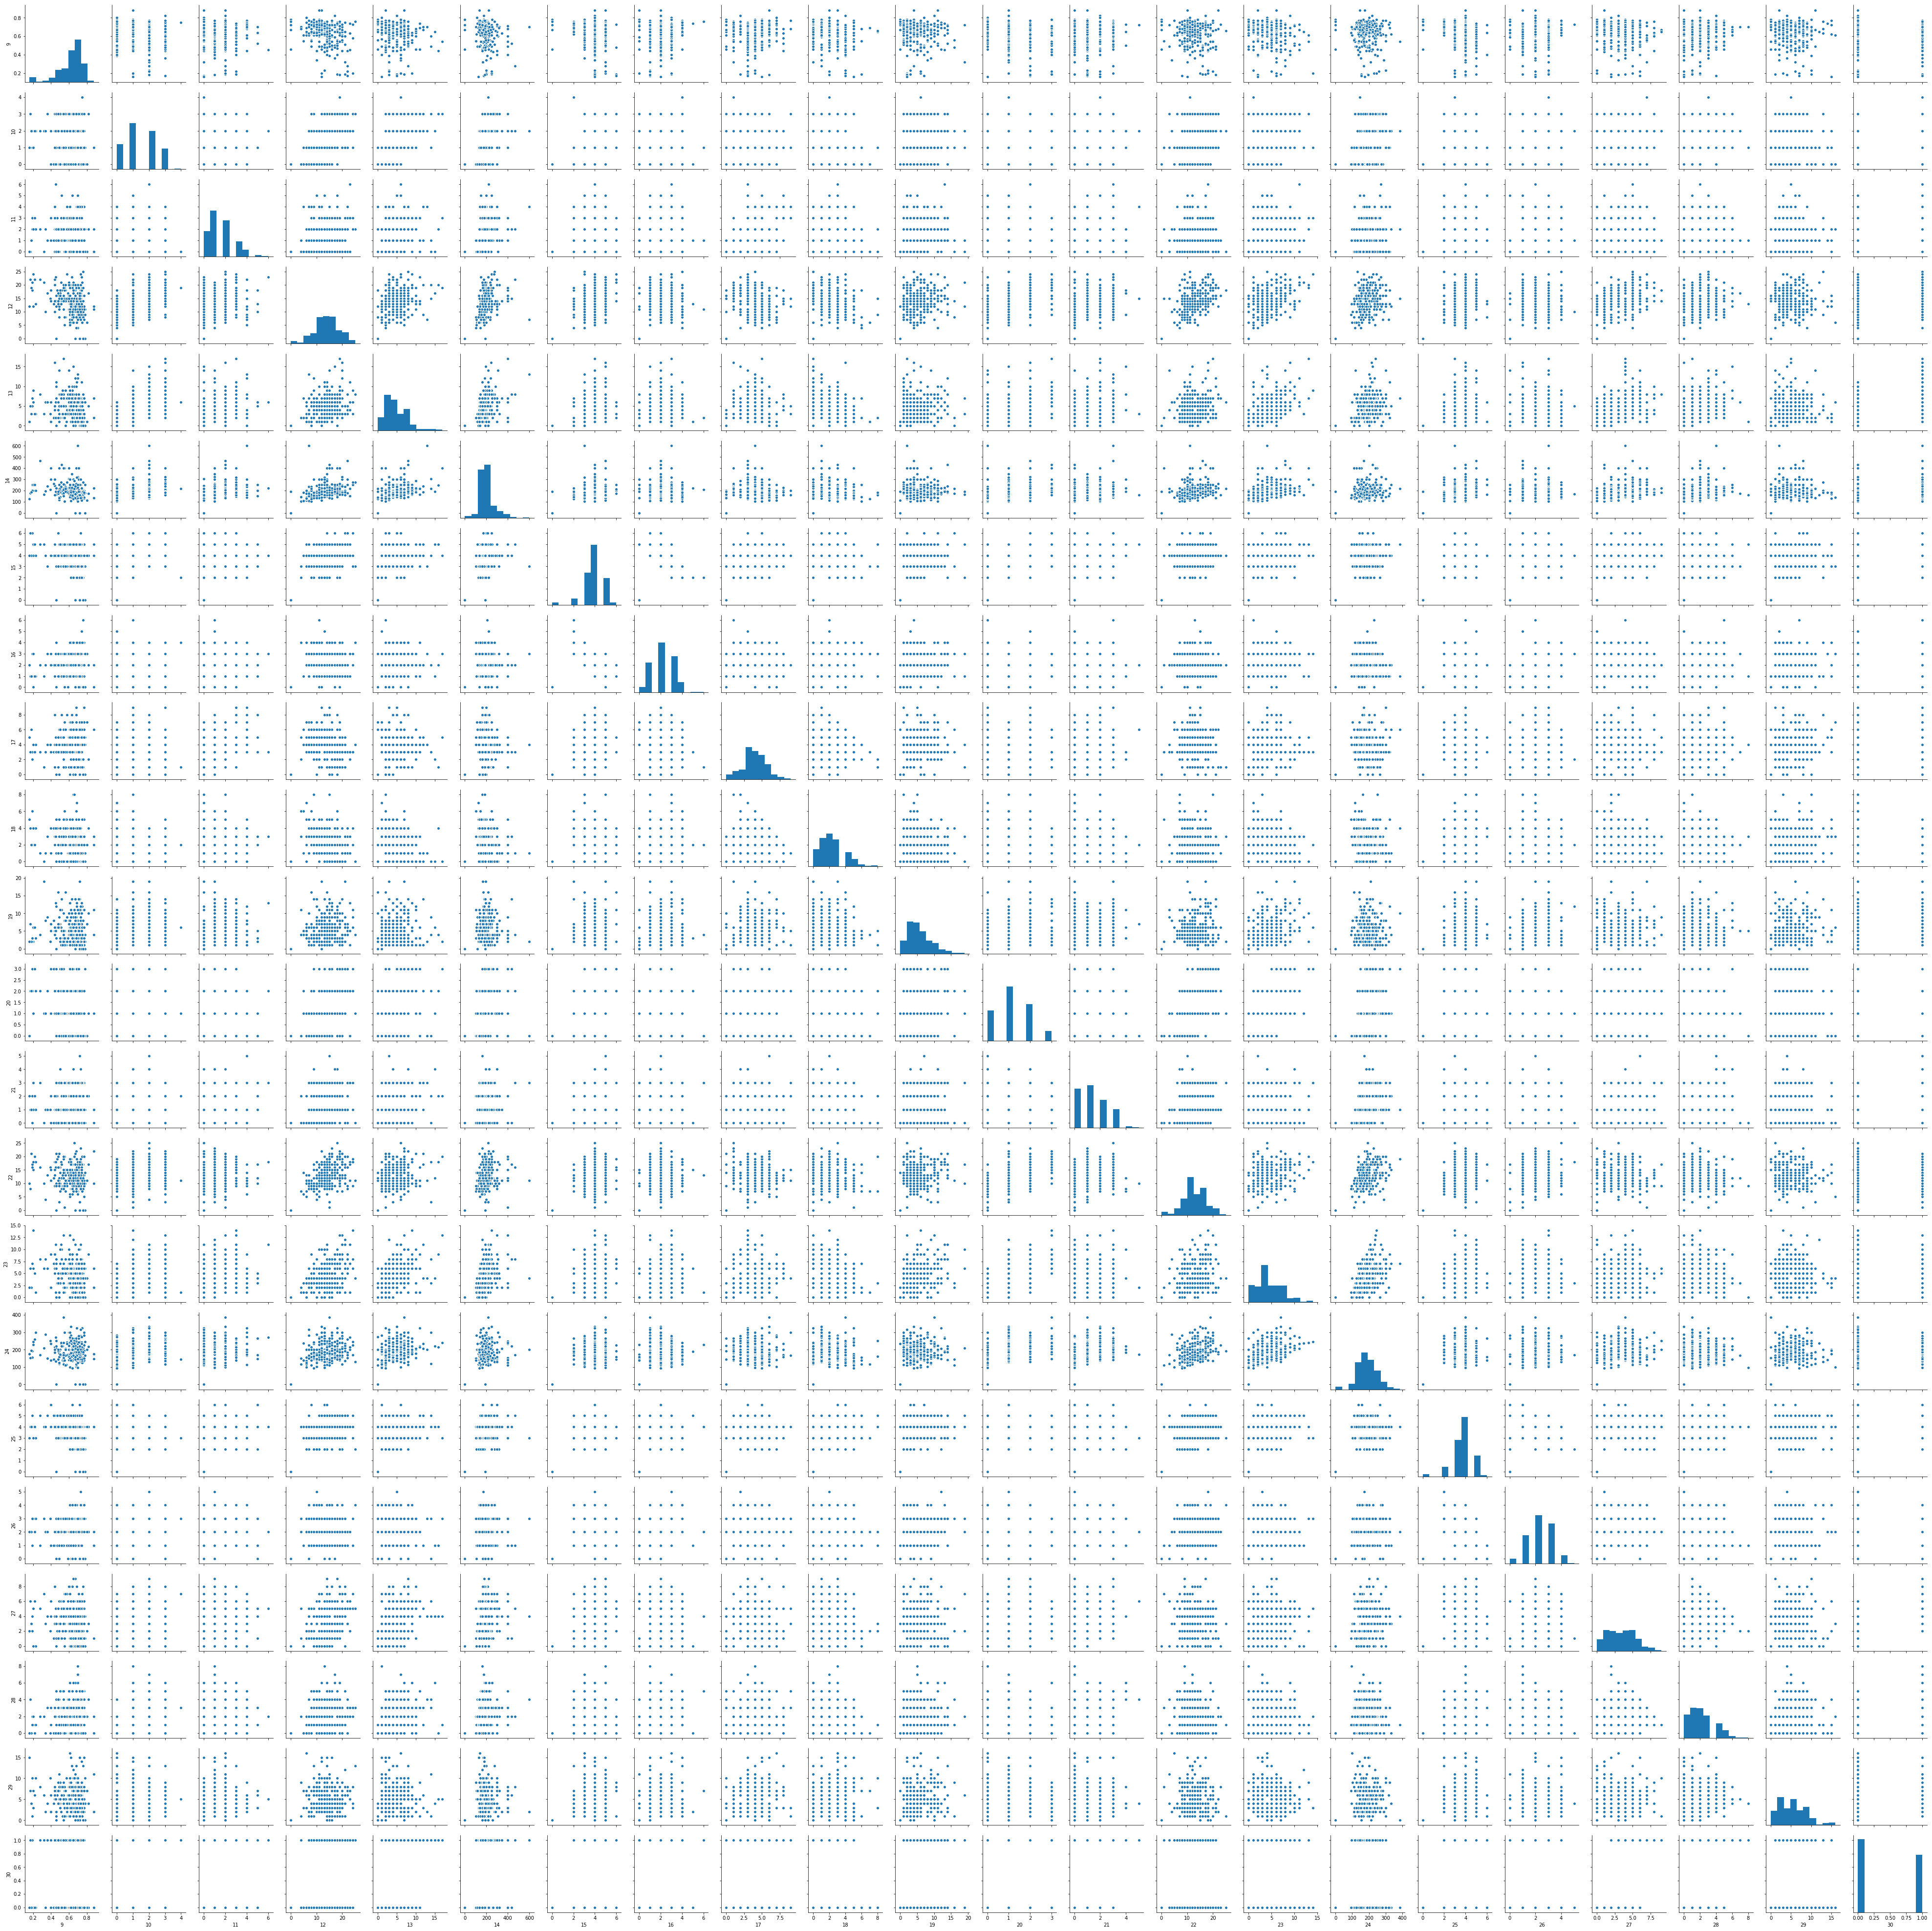

In [170]:
plot_data = train1.iloc[:,8:]
plt.figure(figsize=(10,10))
sns.pairplot(plot_data,palette='coolwarm')
plt.show()

***I didn't infer anything good from the plot.<br>Rename the columns again to their original name***

In [171]:
train1.columns = originalcols

***We will drop the Winner Feature from the train data to make the feature set and alos Game Id, DayOfWeek on which match was played, Date of the Game, and Time of the game, as these attributes does not contibute in the classification.***

In [172]:
x_train1=train1.drop(['Winner (team 1=1, team 2=0)','Game ID','DayOfWeek','DateOfGame','TimeOfGame'],axis=1)
x_train1.columns

Index(['Team 1', 'Team 2', 'City', 'AvgWindSpeed', 'AvgHumidity',
       'Inn 1 Team 1 NOP R>25,SR>125', 'Inn 1 Team 1 NOP R<25, SR>125',
       'Inn 1 Team 1 Total 4s', 'Inn 1 Team 1 Total 6s',
       'Inn 1 Team 1 Max Strike Rate_ALLBatsmen',
       'Inn 1 Team 2 NoP fast bowlers', 'Inn 1 Team 2 NoP Spinners',
       'Inn 1 Team 2 wickets taken_catches_runout',
       'Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 1 Team 2 Extras conceded in_wides_No Balls',
       'Inn 2 Team 2 NOP R>25,SR>125', 'Inn 2 Team 2 NOP R<25, SR>125',
       'Inn 2 Team 2 Total 4s', 'Inn 2 Team 2 Total 6s',
       'Inn 2 Team 2 Max Strike Rate_ALLBatsmen',
       'Inn 2 Team 1 NoP fast bowlers', 'Inn 2 Team 1 NoP Spinners',
       'Inn 2 Team 1 wickets taken_catches_runout',
       'Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 2 Team 1 Extras conceded in_wides_No Balls'],
      dtype='object')

***I will combine Team 1, Team2 and City attributes as they don't contibute anything of their own but they tell us about a very important information about the homeCity of a Team which can be an important factor in a team winning or losing a game.<br>
We will make a new column namely homeCity which will have binary values 0 and 1, where 0 means it is homeCity of Team 2 and 1 means homeCity of Team 1.<br>
We can derive homeCity as the first word in a team's name is its homeCity.***

In [173]:
x_train1['homeCity']=0
for i, row in x_train1.iterrows():
    if(row[0].split()[0]==row[2].split()[0]):
        x_train1.at[i,'homeCity'] = 1
x_train1
# now in the home city column we have 1 if team 1 has its hometown
x_train1=x_train1.drop(['Team 1', 'Team 2', 'City'],axis=1)
x_train1

,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125","Inn 1 Team 1 NOP R<25, SR>125",Inn 1 Team 1 Total 4s,Inn 1 Team 1 Total 6s,Inn 1 Team 1 Max Strike Rate_ALLBatsmen,Inn 1 Team 2 NoP fast bowlers,Inn 1 Team 2 NoP Spinners,Inn 1 Team 2 wickets taken_catches_runout,...,"Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 2 Total 4s,Inn 2 Team 2 Total 6s,Inn 2 Team 2 Max Strike Rate_ALLBatsmen,Inn 2 Team 1 NoP fast bowlers,Inn 2 Team 1 NoP Spinners,Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,homeCity
0,6,0.49,1,1,15,14,216.43,4,2,3,...,0,3,3,120.00,5,0,6,4,11,0
1,7,0.44,3,2,20,16,246.15,5,2,1,...,2,18,9,215.15,4,1,4,0,5,0
2,11,0.23,2,2,13,3,200.00,4,1,4,...,1,18,1,300.00,3,3,0,1,10,0
3,6,0.61,0,2,6,6,140.00,3,3,7,...,0,5,4,100.00,4,2,3,2,16,0
4,6,0.56,3,1,18,5,233.33,5,1,4,...,3,15,6,205.26,4,2,4,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,9,0.77,3,2,16,7,183.33,4,2,5,...,1,20,3,283.33,3,3,3,2,7,1
248,6,0.71,2,1,13,7,161.11,3,3,2,...,0,14,10,280.00,4,2,2,2,6,0
249,7,0.72,2,0,15,3,162.50,5,1,3,...,2,18,3,220.00,4,3,4,2,1,0
250,8,0.71,2,1,13,8,189.36,4,2,3,...,3,13,4,185.71,3,3,5,3,2,0


***Again we have Rename the test columns as it has anomaly in name from the training data.<br>
We will apply the same procedure applied for training data on the test data.***

In [174]:
test1 = pd.read_csv("sigtuple_test.csv")
test1 = test1.rename(columns = {"CityOfGame": "City", "Day":"DayOfWeek"})
#test1.columns


In [175]:
y_test1 = test1['Winner (team 1=1, team 2=0)']
x_test1=test1.drop(['Winner (team 1=1, team 2=0)','Game ID','DayOfWeek','DateOfGame','TimeOfGame'],axis=1)
x_test1

,Team 1,Team 2,City,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125","Inn 1 Team 1 NOP R<25, SR>125",Inn 1 Team 1 Total 4s,Inn 1 Team 1 Total 6s,Inn 1 Team 1 Max Strike Rate_ALLBatsmen,...,"Inn 2 Team 2 NOP R>25,SR>125","Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 2 Total 4s,Inn 2 Team 2 Total 6s,Inn 2 Team 2 Max Strike Rate_ALLBatsmen,Inn 2 Team 1 NoP fast bowlers,Inn 2 Team 1 NoP Spinners,Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls
0,Electronic City Power Savers,Marathalli Chokers,Electronic City,5,0.62,1,1,6,1,150.00,...,1,0,9,5,142.85,3,3,1,1,3
1,Koramangala Traffic Jammers,Sarjapur Water Tankers,Koramangala,6,0.66,1,3,6,5,200.00,...,1,1,8,4,210.00,3,2,1,1,1
2,HSR High Rent Payers,Marathalli Chokers,Marathalli,5,0.64,0,2,11,1,155.55,...,0,1,8,1,166.66,4,2,2,7,4
3,Indranagar Pub Watchers,Silkboard Slow Movers,Indranagar,5,0.64,1,3,23,3,366.66,...,2,3,14,4,166.66,2,4,6,3,2
4,Whitefield Water Loggers,Sarjapur Water Tankers,Whitefield,5,0.62,2,0,14,5,157.89,...,1,2,13,2,160.00,4,2,6,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Indranagar Pub Watchers,Marathalli Chokers,Indranagar,7,0.75,1,2,13,6,200.00,...,1,0,16,3,150.00,4,2,0,0,16
72,Koramangala Traffic Jammers,Sarjapur Water Tankers,HSR,6,0.74,2,1,14,6,218.18,...,0,4,14,3,200.00,3,3,4,4,5
73,Electronic City Power Savers,Marathalli Chokers,Whitefield,6,0.74,3,0,23,6,255.00,...,1,3,14,5,200.00,3,3,5,4,6
74,Electronic City Power Savers,Sarjapur Water Tankers,Electronic City,6,0.74,3,1,24,9,275.00,...,1,5,7,7,171.42,3,2,7,3,7


In [176]:
x_test1['homeCity']=0
for i, row in x_test1.iterrows():
    if(row[0].split()[0]==row[2].split()[0]):
        x_test1.at[i,'homeCity'] = 1
x_test1
# now in the home city column we have 1 if team 1 has its hometown
x_test1=x_test1.drop(['Team 1', 'Team 2', 'City'],axis=1)
x_test1

,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125","Inn 1 Team 1 NOP R<25, SR>125",Inn 1 Team 1 Total 4s,Inn 1 Team 1 Total 6s,Inn 1 Team 1 Max Strike Rate_ALLBatsmen,Inn 1 Team 2 NoP fast bowlers,Inn 1 Team 2 NoP Spinners,Inn 1 Team 2 wickets taken_catches_runout,...,"Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 2 Total 4s,Inn 2 Team 2 Total 6s,Inn 2 Team 2 Max Strike Rate_ALLBatsmen,Inn 2 Team 1 NoP fast bowlers,Inn 2 Team 1 NoP Spinners,Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,homeCity
0,5,0.62,1,1,6,1,150.00,4,2,9,...,0,9,5,142.85,3,3,1,1,3,1
1,6,0.66,1,3,6,5,200.00,3,3,3,...,1,8,4,210.00,3,2,1,1,1,1
2,5,0.64,0,2,11,1,155.55,4,2,4,...,1,8,1,166.66,4,2,2,7,4,0
3,5,0.64,1,3,23,3,366.66,4,2,1,...,3,14,4,166.66,2,4,6,3,2,1
4,5,0.62,2,0,14,5,157.89,4,2,6,...,2,13,2,160.00,4,2,6,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,7,0.75,1,2,13,6,200.00,6,1,5,...,0,16,3,150.00,4,2,0,0,16,1
72,6,0.74,2,1,14,6,218.18,4,1,3,...,4,14,3,200.00,3,3,4,4,5,0
73,6,0.74,3,0,23,6,255.00,6,1,4,...,3,14,5,200.00,3,3,5,4,6,0
74,6,0.74,3,1,24,9,275.00,3,3,3,...,5,7,7,171.42,3,2,7,3,7,1


***The features are not on the same scale. For example Inn 1 Team 1 Max Strike Rate_ALLBatsmen and AvgHumidity. Features should be on the same scale for classification algorithms such as logistic regression (gradient descent) to converge smoothly.I have applied the algorithms without using Feature Scaling and the performance of KNN and SVC was very bad but it drastically improved after Feature Scaling.<br>
So we will apply Feature Scaling on the data.***

In [177]:
sc = StandardScaler()
x_train1 = sc.fit_transform(x_train1)
x_test1 = sc.transform(x_test1)

In [178]:
x_train1

array([[-0.61331307, -1.02923041, -0.43970562, ...,  1.18764708,
         1.75074893, -0.78446454],
       [-0.18754201, -1.40986742,  1.59342864, ..., -1.30122663,
        -0.10428427, -0.78446454],
       [ 1.51554221, -3.00854289,  0.57686151, ..., -0.67900821,
         1.44157673, -0.78446454],
       ...,
       [-0.18754201,  0.72169987,  0.57686151, ..., -0.05678978,
        -1.34097308, -0.78446454],
       [ 0.23822904,  0.64557246,  0.57686151, ...,  0.56542865,
        -1.03180088, -0.78446454],
       [ 0.23822904,  0.56944506,  0.57686151, ...,  1.18764708,
        -1.03180088,  1.27475488]])

***Now our data is ready and we will apply different classification algorithms like Logistic Regression, KNN, GaussianNB, SVC and Random Forest.***

In [179]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train1, y_train1)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(x_test1, y_test1)))


Accuracy of Logistic regression classifier on training set: 0.91


In [180]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train1, y_train1)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(x_test1, y_test1)))
#print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.89


In [181]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train1, y_train1)
print('Accuracy of GNB classifier on training set: {:.2f}'.format(gnb.score(x_test1, y_test1)))
#print('Accuracy of GNB classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.83


In [182]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(x_train1, y_train1)
print('Accuracy of SVM classifier on training set: {:.2f}'.format(svm.score(x_test1, y_test1)))
#print('Accuracy of SVM classifier on test set: {:.2f}'.format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.88


In [183]:
for i in range(10,25):
    regressor = RandomForestRegressor(n_estimators=2*i, random_state=0)
    regressor.fit(x_train1, y_train1)
    #y_pred = regressor.predict(X_test)
    print('Accuracy of rf classifier on training set: {:.2f}'.format(regressor.score(x_test1, y_test1)))


Accuracy of rf classifier on training set: 0.56
Accuracy of rf classifier on training set: 0.56
Accuracy of rf classifier on training set: 0.57
Accuracy of rf classifier on training set: 0.56
Accuracy of rf classifier on training set: 0.56
Accuracy of rf classifier on training set: 0.58
Accuracy of rf classifier on training set: 0.58
Accuracy of rf classifier on training set: 0.59
Accuracy of rf classifier on training set: 0.60
Accuracy of rf classifier on training set: 0.60
Accuracy of rf classifier on training set: 0.61
Accuracy of rf classifier on training set: 0.60
Accuracy of rf classifier on training set: 0.61
Accuracy of rf classifier on training set: 0.61
Accuracy of rf classifier on training set: 0.61


***We ran the Random Forest Classifier for a range of values of trees and found out that the best result with Random Forest comes when no. of trees are approx 40 i.e 0.61***

***We can see that all these algorithms worked better than CatBoost except Random Forest and the best performance is given by Logistic Regression. Hence, we will use logistic regressor for our predictions and also for probability calculation. ***

In [184]:
y_pred_rf=logreg.predict(x_test1)
y_pred_rf_prob=logreg.predict_proba(x_test1)

# which team wins
for idx, i in enumerate(y_pred_rf):
    print('winning team is : ',end='')
    if(i.round()):
        print(' Team 1 '+ X_test.iloc[idx,1] ,end='')
    else:
        print(' Team 2 ' + X_test.iloc[idx,2],end='')
    print(' & it wins by probablity : ', end='')
    if(i.round()):
        print(y_pred_rf_prob[idx,1])
    else:
        print(y_pred_rf_prob[idx,0])

winning team is :  Team 2 Marathalli Chokers  & it wins by probablity : 0.9996126012063657
winning team is :  Team 2 Sarjapur Water Tankers & it wins by probablity : 0.9755392333433207
winning team is :  Team 1 HSR High Rent Payers & it wins by probablity : 0.9205532518199016
winning team is :  Team 1 Indranagar Pub Watchers & it wins by probablity : 0.9979068486538818
winning team is :  Team 1 Whitefield Water Loggers  & it wins by probablity : 0.9623962074815813
winning team is :  Team 1 Electronic City Power Savers & it wins by probablity : 0.9998290127208764
winning team is :  Team 1 Indranagar Pub Watchers & it wins by probablity : 0.9978856784476392
winning team is :  Team 1 HSR High Rent Payers & it wins by probablity : 0.9511757000898626
winning team is :  Team 2 Marathalli Chokers  & it wins by probablity : 0.8641633296697108
winning team is :  Team 1 Koramangala Traffic Jammers & it wins by probablity : 0.9985240573911495
winning team is :  Team 2 Sarjapur Water Tankers & it 

***These are the probabilities of winning of all the matches in test data.***